In [77]:
# !pip install -U kaleido
# !pip install --upgrade plotly

### Import Libraries

In [51]:
import pandas as pd
from matplotlib import pyplot as plt 
from geopy.geocoders import Nominatim
from time import sleep

### Import data

In [52]:
df = pd.read_csv('D:/Daniels/exercises/ubuntu/phd_work/data/pprl_papers_data_extraction.csv')
df.head()

,search_#,study_title,link,geographic_region,state_country,city,evaluation,date_done,year,topic,...,More explanation on AIMS,Sections,Authors,Skimming_through_scanning,fulltext,mendeley_zotero,citations,Authors_x,Databases,author_affiliation
0,714153228727,NaN,https://doi.org/,NaN,NaN,NaN,NaN,7/10/2025,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,714153228967,Designing and piloting a generic research arch...,https://doi.org/10.1186/s12967-020-02547-x,Europe;,Germany;,NaN,great,7/14/2025,NaN,"Secondary data, Trusted Third Party (TTP), pha...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,714153228462,National administrative record linkage between...,https://doi.org/10.1136/bmjopen-2020-043540,Europe;,England;,NaN,great-practical,7/9/2025,2020.0,linkage rate; missed matches; gold-­standard s...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,714153228270,Design and evaluation of a data anonymization ...,https://doi.org/10.1038/s41597-020-00773-y,Europe;,Germany;,NaN,great-practical,7/9/2025,2020.0,Public Use File (PUF); Scientific Use Files (S...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,714153228538,Optimization of the Mainzelliste software for ...,https://doi.org/10.1186/s12967-020-02678-1,Europe;,Germany;,German city;,great,7/8/2025,2021.0,"blocking methods (such as Soundex, phonetic bl...",...,NaN,NaN,Rohde F,Yes,NaN,NaN,J Transl Med. 2021 Jan 15;19(1):33. doi: 10.11...,Rohde F,J Transl Med,NaN


In [53]:
df.shape

(529, 88)

### Split locations

In [54]:
# Remove trailing semicolons and split into lists
df['countries_list'] = df['state_country'].str.rstrip(';').str.split(';')

# Explode into multiple rows
df_exploded = df.explode('countries_list')

# Clean up spaces and underscores
df_exploded['countries_clean'] = df_exploded['countries_list'].str.replace('_', ' ').str.strip()

# Drop NaNs or empty values
df_exploded = df_exploded[df_exploded['countries_clean'].notna() & (df_exploded['countries_clean'] != '')]


In [55]:
df_exploded.countries_clean.nunique()

65

In [56]:
geolocator = Nominatim(user_agent="geoapi")

# Define function with delay to avoid rate-limiting
def geocode_place(place):
    try:
        loc = geolocator.geocode(place)
        if loc:
            return pd.Series([loc.latitude, loc.longitude])
    except:
        return pd.Series([None, None])
    return pd.Series([None, None])

# Apply with delay
df_exploded[['lat', 'lon']] = df_exploded['countries_clean'].apply(lambda x: geocode_place(x))

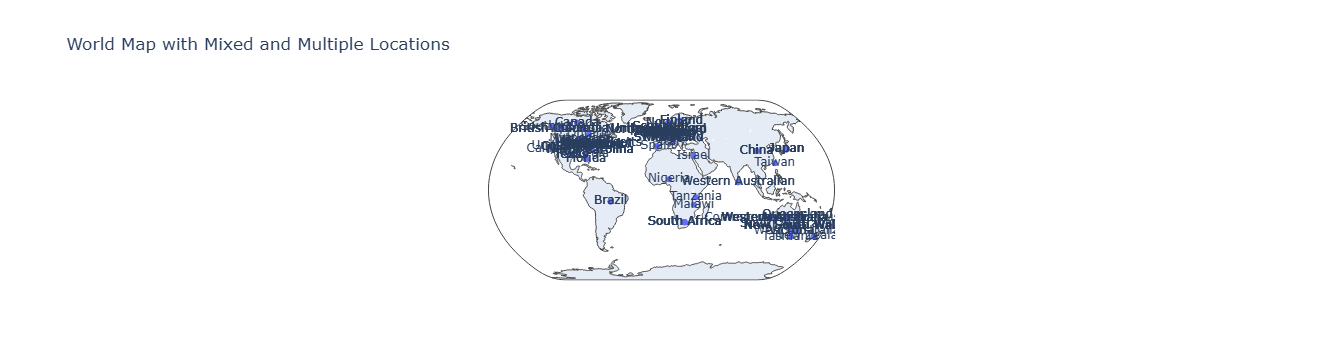

In [57]:
import plotly.express as px

fig = px.scatter_geo(df_exploded,
                     lat='lat',
                     lon='lon',
                     text='countries_clean',
                     projection="natural earth",
                     title="World Map with Mixed and Multiple Locations")

fig.write_html("maps/map_output.html")

fig.show()


### Map without country names (Size not factored)

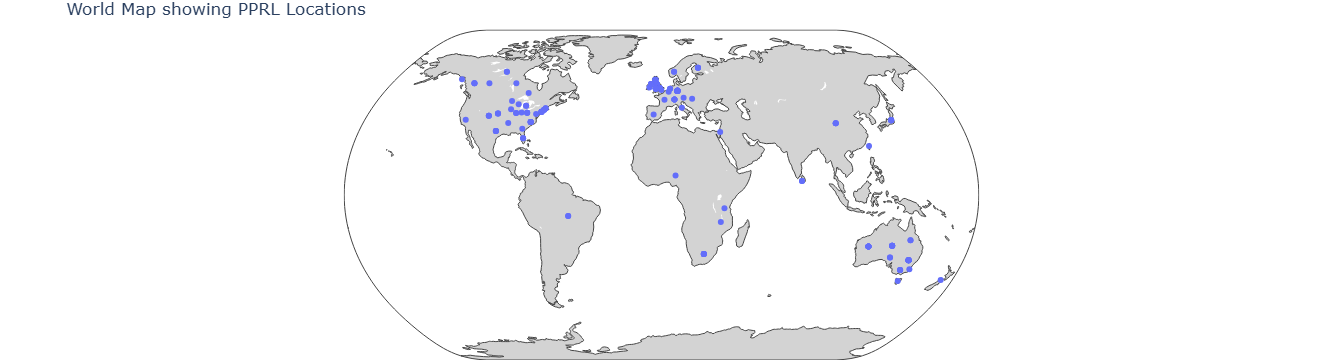

In [58]:
import plotly.express as px

fig = px.scatter_geo(df_exploded,
                     lat='lat',
                     lon='lon',
                     # text='countries_clean',
                     hover_name='countries_clean',
                     projection="natural earth",
                     title="World Map showing PPRL Locations")

# Hide country names (labels), keep borders and land
fig.update_geos(
    showcountries=False,    # hides country names
    showcoastlines=True,
    showland=True,
    landcolor="lightgray"
)

# Optional: adjust layout margins if needed
fig.update_layout(
    margin={"r":0, "t":30, "l":0, "b":0}
)

# Save map
fig.write_html("maps/map_output_ii.html")

# Show map
fig.show()


### Map 3 - with size as a factor

In [59]:
# Count occurrences of each location
size_df = df_exploded['countries_clean'].value_counts().reset_index()
size_df.columns = ['countries_clean', 'size']

# Merge back to main DataFrame
df_exploded = df_exploded.merge(size_df, on='countries_clean')
df_exploded.head()

,search_#,study_title,link,geographic_region,state_country,city,evaluation,date_done,year,topic,...,mendeley_zotero,citations,Authors_x,Databases,author_affiliation,countries_list,countries_clean,lat,lon,size
0,714153228967,Designing and piloting a generic research arch...,https://doi.org/10.1186/s12967-020-02547-x,Europe;,Germany;,NaN,great,7/14/2025,NaN,"Secondary data, Trusted Third Party (TTP), pha...",...,NaN,NaN,NaN,NaN,NaN,Germany,Germany,51.163818,10.447831,14
1,714153228270,Design and evaluation of a data anonymization ...,https://doi.org/10.1038/s41597-020-00773-y,Europe;,Germany;,NaN,great-practical,7/9/2025,2020.0,Public Use File (PUF); Scientific Use Files (S...,...,NaN,NaN,NaN,NaN,NaN,Germany,Germany,51.163818,10.447831,14
2,714153228538,Optimization of the Mainzelliste software for ...,https://doi.org/10.1186/s12967-020-02678-1,Europe;,Germany;,German city;,great,7/8/2025,2021.0,"blocking methods (such as Soundex, phonetic bl...",...,NaN,J Transl Med. 2021 Jan 15;19(1):33. doi: 10.11...,Rohde F,J Transl Med,NaN,Germany,Germany,51.163818,10.447831,14
3,714153228748,A Federated Record Linkage Algorithm for Secur...,https://doi.org/10.3233/SHTI210062,Europe;,Germany;,NaN,great-practical,6/28/2025,2021.0,NaN,...,NaN,Stud Health Technol Inform. 2021 May 24;278:14...,Heidt CM,Stud Health Technol Inform,NaN,Germany,Germany,51.163818,10.447831,14
4,714153228690,Mainzelliste SecureEpiLinker (MainSEL): Privac...,https://doi.org/10.1093/bioinformatics/btaa764,Europe;,Germany;,NaN,good,6/24/2025,2022.0,Linkage blocking techniques recommended to imp...,...,NaN,Bioinformatics. 2022 Mar 4;38(6):1657-1668. do...,Stammler S,Bioinformatics,NaN,Germany,Germany,51.163818,10.447831,14


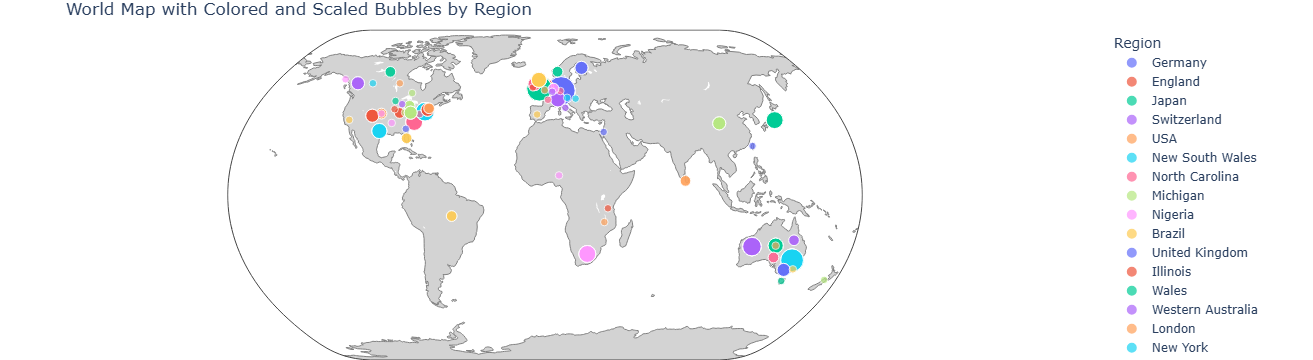

In [79]:
import plotly.express as px

fig = px.scatter_geo(
    df_exploded,
    lat='lat',
    lon='lon',
    hover_name='countries_clean',  # Appears on hover only
    color='countries_clean',                # Colors by region
    size='size',                  # Bubble size
    projection="natural earth",
    title="World Map with Colored and Scaled Bubbles by Region"
)

# Hide country labels and customize map appearance
fig.update_geos(
    showcountries=False,
    showland=True,
    landcolor="lightgray",
    showcoastlines=True,
    coastlinecolor="gray"
)

# Customize layout and legend appearance
fig.update_layout(
    legend_title_text='Region',
    margin={"r":0,"t":30,"l":0,"b":0}
)

# Save and show
# fig.write_image("maps/pprl_map_colored_iii.png", scale=2)
fig.write_html("maps/pprl_map_colored_iii.html")
fig.show()

In [71]:
import kaleido
print("Kaleido is working!")

Kaleido is working!


C:\Users\dmaina.AD\Anaconda3\envs\phd_work\lib\site-packages\kaleido\__init__.py:14: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




### End of the maps